In [8]:
!pip install --upgrade pip
!pip install tensorflow matplotlib scikit-learn
!pip install jupyterlab
!pip install pillow opencv-python


  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip


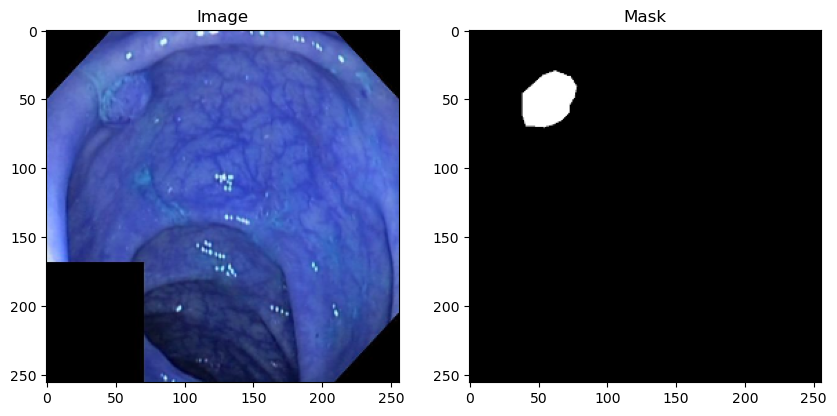

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to your dataset
image_path = "images"
mask_path = "masks"

# Load and preprocess data
def load_data(image_path, mask_path, image_size=(256, 256)):
    images, masks = [], []
    for file_name in os.listdir(image_path):
        # Load image and mask
        img = cv2.imread(os.path.join(image_path, file_name))
        mask = cv2.imread(os.path.join(mask_path, file_name), 0)  # Load as grayscale
        
        # Resize and normalize
        img = cv2.resize(img, image_size) / 255.0
        mask = cv2.resize(mask, image_size) / 255.0
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images, dtype=np.float32)
    masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)  # Add channel dimension
    return images, masks

# Load and split dataset
images, masks = load_data(image_path, mask_path)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Display sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(y_train[0].squeeze(), cmap="gray")
plt.title("Mask")
plt.show()


In [10]:
from tensorflow.keras import layers, models

def unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return models.Model(inputs, outputs)

# Create the model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 256)     │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 384)     │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 128)     │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 256, 256, 128)     │               0 │ conv2d_7[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 192)     │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=20
)


Epoch 1/20
11/50 ━━━━━━━━━━━━━━━━━━━━ 4:30 7s/step - accuracy: 0.8356 - loss: 0.3528

KeyboardInterrupt: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8276 - loss: 0.3679
Validation Loss: 0.35581859946250916, Accuracy: 0.8335669636726379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


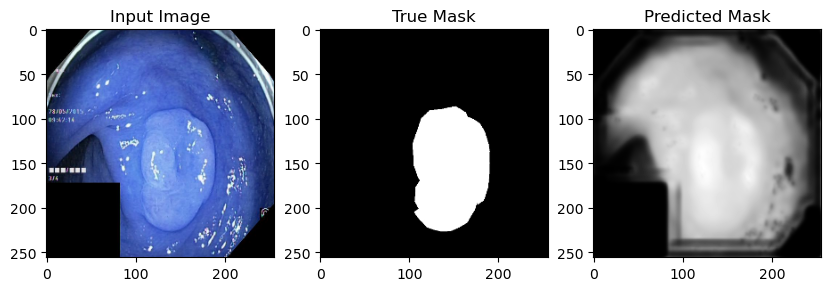

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Accuracy: {accuracy}")

# Predict and visualize
predicted_mask = model.predict(np.expand_dims(X_val[0], axis=0))[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_val[0])
plt.title("Input Image")
plt.subplot(1, 3, 2)
plt.imshow(y_val[0].squeeze(), cmap="gray")
plt.title("True Mask")
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.show()
